In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [2]:
Dict = dict(np.load(r'./Data/Fig_2_data.npy', allow_pickle=True).item())

Shots_0 = Dict['Shots_0_IQ'][:3000]
Shots_1 = Dict['Shots_1_IQ'][:3000]
Shots_2 = Dict['Shots_2_IQ'][:3000]
Shots_lru = Dict['Shots_lru_IQ'][:3000]
classifier = Dict['classifier']
dec_bounds = Dict['dec_bounds']
M = Dict['Ass_matrix']
LR_fraction_a = Dict['LR_fraction_a']
Amplitude_a = Dict['Amplitude_a']
Frequency_a = Dict['Frequency_a']
LR_fraction_b = Dict['LR_fraction_b']
Amplitude_b = Dict['Amplitude_b']
Duration_b = Dict['Duration_b']

### Fit data

In [3]:
# Fit calibration shots to gaussian distributions
from scipy.optimize import curve_fit
def twoD_Gaussian(data, amplitude, x0, y0, sigma_x, sigma_y, theta):
    x, y = data
    x0 = float(x0)
    y0 = float(y0)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-x0)**2) + 2*b*(x-x0)*(y-y0) 
                            + c*((y-y0)**2)))
    return g.ravel()
def _fit_2D_gaussian(X, Y):
    counts, _x, _y = np.histogram2d(X, Y, bins=[100, 100], density=True)
    x = (_x[:-1] + _x[1:]) / 2
    y = (_y[:-1] + _y[1:]) / 2
    _x, _y = np.meshgrid(_x, _y)
    x, y = np.meshgrid(x, y)
    p0 = [counts.max(), np.mean(X), np.mean(Y), .2, .2, 0]
    popt, pcov = curve_fit(twoD_Gaussian, (x, y), counts.T.ravel(), p0=p0)
    return popt
popt_0 = _fit_2D_gaussian(Shots_0[:,0], Shots_0[:,1])
popt_1 = _fit_2D_gaussian(Shots_1[:,0], Shots_1[:,1])
popt_2 = _fit_2D_gaussian(Shots_2[:,0], Shots_2[:,1])

### Plot data

Text(0.5, 1.0, 'Assignment probability\nmatrix')

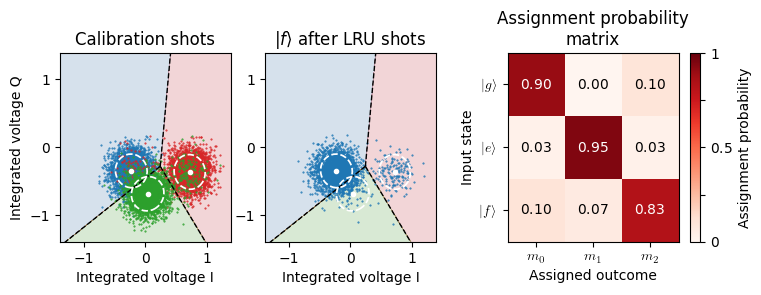

In [4]:
fig, axs = plt.subplots(figsize=(7.5,2.5), ncols=3, dpi=100)

######################
# Plot readout shots #
######################
# Plot raw calibration shots
axs[0].plot(Shots_0[:,0], Shots_0[:,1], '.', color='C0', alpha=1, markersize=1)
axs[0].plot(Shots_1[:,0], Shots_1[:,1], '.', color='C3', alpha=1, markersize=1)
axs[0].plot(Shots_2[:,0], Shots_2[:,1], '.', color='C2', alpha=1, markersize=1)
# Plot f state after LRU shots
axs[1].plot(Shots_lru[:,0], Shots_lru[:,1], '.', color='C0', alpha=1, markersize=1)
for i in range(2):
    # Plot fit results
    axs[i].plot(popt_0[1], popt_0[2], 'o', color='white', markersize=3)
    axs[i].plot(popt_1[1], popt_1[2], 'o', color='white', markersize=3)
    axs[i].plot(popt_2[1], popt_2[2], 'o', color='white', markersize=3)
    # Draw 4sigma ellipse around mean
    from matplotlib.patches import Ellipse
    circle_0 = Ellipse((popt_0[1], popt_0[2]),
                      width=3*popt_0[3], height=3*popt_0[4],
                      angle=-popt_0[5]*180/np.pi,
                      ec='white', fc='none', ls='--', lw=1.25, zorder=10)
    axs[i].add_patch(circle_0)
    circle_1 = Ellipse((popt_1[1], popt_1[2]),
                      width=3*popt_1[3], height=3*popt_1[4],
                      angle=-popt_1[5]*180/np.pi,
                      ec='white', fc='none', ls='--', lw=1.25, zorder=10)
    axs[i].add_patch(circle_1)
    circle_2 = Ellipse((popt_2[1], popt_2[2]),
                      width=3*popt_2[3], height=3*popt_2[4],
                      angle=-popt_2[5]*180/np.pi,
                      ec='white', fc='none', ls='--', lw=1.25, zorder=10)
    axs[i].add_patch(circle_2)
    # Plot classifier zones
    from matplotlib import colors, patches
    _all_shots = np.concatenate((Shots_0, Shots_1, Shots_2))
    _lim = np.max([ np.max(np.abs(_all_shots[:,0]))*1.1, np.max(np.abs(_all_shots[:,1]))*1.1 ])
    X, Y = np.meshgrid(np.linspace(-_lim, _lim, 1001), np.linspace(-_lim, _lim, 1001))
    pred_labels = classifier.predict(np.c_[X.ravel(), Y.ravel()])
    pred_labels = pred_labels.reshape(X.shape)
    cmap = colors.LinearSegmentedColormap.from_list("", ["C0","C3","C2"])
    cs = axs[i].contourf(X, Y, pred_labels, cmap=cmap, alpha=0.2)
    # Plot decision boundary
    for bound in ['01', '12', '02']:
        _x0, _y0 = dec_bounds['mean']
        _x1, _y1 = dec_bounds[bound]
        a = (_y1-_y0)/(_x1-_x0)
        b = _y0 - a*_x0
        _xlim = 1e2*np.sign(_x1-_x0)
        _ylim = a*_xlim + b
        axs[i].plot([_x0, _xlim], [_y0, _ylim], 'k--', lw=1)
    axs[i].set_xticks([-2, -1, 0, 1, 2])
    axs[i].set_yticks([-2, -1, 0, 1, 2])
    axs[i].set_xlim(-_lim, _lim)
    axs[i].set_ylim(-_lim, _lim)
    axs[i].set_xlabel('Integrated voltage I')
axs[0].set_ylabel('Integrated voltage Q')
axs[0].set_title('Calibration shots')
axs[1].set_title('$|f\\rangle$ after LRU shots')

##########################
# Plot assignment matrix #
##########################
im = axs[2].pcolormesh(np.arange(0,4)-.5, np.arange(0,4)[::-1]-.5, M, cmap=plt.cm.Reds, clim=(0, 1))
rows, cols = np.shape(M)
for i in range(rows):
    for j in range(cols):
        c = M[i, j]
        if c > .5:
            col = 'white'
        else:
            col = 'black'
        axs[2].text(j, 2-i, '${:.2f}$'.format(c),
                va='center', ha='center', color=col)
axs[2].set_xticks([0,1,2])
axs[2].set_yticks([0,1,2][::-1])
axs[2].set_xticklabels([r'$m_0$', r'$m_1$', r'$m_2$'], usetex=True)
axs[2].set_yticklabels([r'$|g\rangle$', r'$|e\rangle$', r'$|f\rangle$'], usetex=True)
axs[2].set_xlabel('Assigned outcome')
axs[2].set_ylabel('Input state')
cbar = plt.colorbar(im, ax=axs[2], orientation='vertical',location='right')
cbar.set_label(r'Assignment probability')
cbar.set_ticks([0, .25, .50, .75, 1])
cbar.set_ticklabels(['$0$', '','$0.5$', '', '$1$'])
_pos = axs[2].get_position()
_pos = [_pos.x0+.05, _pos.y0, _pos.width*1.25, _pos.height]
axs[2].set_position(_pos)
cbar_ax = fig.get_axes()[-1]
_pos = cbar_ax.get_position()
_pos = [_pos.x0+.1, _pos.y0, _pos.width*1.25, _pos.height]
cbar_ax.set_position(_pos)
axs[2].set_title('Assignment probability\nmatrix')

### Calibration landscapes

[Text(0, 1, ''), Text(0, 2, ''), Text(0, 3, '')]

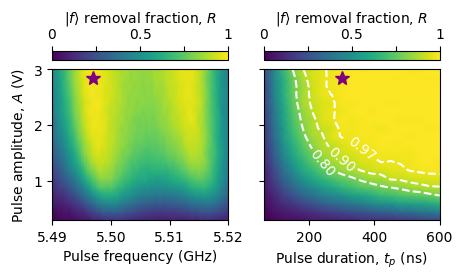

In [5]:
fig, axs = plt.subplots(figsize=(5,2.5), ncols=2, dpi=100)

# Frequency vs amplitude plot
im = axs[0].pcolormesh(Frequency_a, Amplitude_a, LR_fraction_a,
                       cmap='viridis', vmin=0, vmax=1, shading='gouraud')

max_idx = np.unravel_index(np.argmax(LR_fraction_a), LR_fraction_a.shape)
axs[0].plot(Frequency_a[max_idx], Amplitude_a[max_idx], '*', color='purple', markersize=10)
cbar = plt.colorbar(im, ax=axs[0], orientation='horizontal',location='top')
cbar.set_ticks([0, .25,.5, .75, 1])
cbar.set_ticklabels(['$0$', '','$0.5$', '', '$1$'])
cbar.set_label('$|f\\rangle$ removal fraction, $R$')
axs[0].set_xlabel('Pulse frequency (GHz)')
axs[0].set_yticks([1, 2, 3])
axs[0].set_ylabel('Pulse amplitude, $A$ (V)')

# Duration vs amplitude plot
im = axs[1].pcolormesh(Duration_b, Amplitude_b, LR_fraction_b,
                       cmap='viridis', vmin=0, vmax=1, shading='gouraud')
CS1=axs[1].contour(Duration_b, Amplitude_b, LR_fraction_b, [.80, .90, 0.97],
              colors='w', linestyles='--')
axs[1].clabel(CS1, inline=True, fontsize=10)
axs[1].plot(300, Amplitude_a[max_idx], '*', color='purple', markersize=10)
cbar = plt.colorbar(im, ax=axs[1], orientation='horizontal', location='top')
cbar.set_label('$|f\\rangle$ removal fraction, $R$')
cbar.set_ticks([0, .25, .5, .75, 1])
cbar.set_ticklabels(['$0$', '','$0.5$', '', '$1$'])
axs[1].set_xlabel('Pulse duration, $t_p$ (ns)')
axs[1].set_yticks([1, 2, 3])
axs[1].set_yticklabels(['', '', ''])